---
title: "The importantance of propper initializtaion"
author: "Alex Kelly"
format:
  html:
    code-fold: true
    toc : true
    numbered-sections : true
jupyter: python3
draft : False
---

# Why am I writing about LSUV?

I'm watching online videos series by Fast.ai where we are looking at re-creating neural networks from scratch using Python
ensuring we fully understand inner workings of each aspect of a neural network. This will allow me to create new techniques
and improve existing techniques and enable me to piece together the right neural network for the right task.   

On top of that we meet up online for a study group and share/discuss what we have been studying.  This blog post is why we need
a better way to initialize weights than just choosing random values.

# Why initialization model weights before starting the optimization  

![](weight_initialization.png)


Proper initialization can affect how quickly the model converges to a minimum loss, or even whether it converges at all.  It's not just about the initialization of the 1st layer of weights, its about all of the layers weights from the 1st to the last.  

Here are a few key points on weight initializations:

1. The hardware has floating point limitations that mean it processes a limited number of bits and stores in a limited amount of memory.   if the weights are too high or too low, then the resulting calculations can exceed the numerical range that can be represented in the specified memory, leading to what is known as exploding or vanishing gradients (i.e.. inactive neurons) at any level in the neural  network.  This results in information lost, which are called inactive neurons or neurons that dont contribute to the end result in a optimal way.  
2.  The mean should be close to zero,  if the number is far away from zero, you will more likely end up with exploding or vanishing neurons (i.e.. dead neurons) that don't contribute to the end prediction or classification.  Enforcing a mean of zero is a way to optimize the weights so when calculated against the inputs they give a optimal result in the floating point range that the hardware can handle.
3. The standard deviation should be near 1 so that the values don't vary too far from the mean (i.e. 0 mentioned in point 2).  A standard deviation that's too high or too low could lead to weights that are too disparate or too similar, affecting the learning dynamics.

# LSUV vs other weight optimization techniques

Each model comes with its own issues and choosing the right initialization model is key to success.  Some initializations work better with large models, some with small and some depend on the activation functions, sometimes you have to experiment to see which ones work best with your data and model.  Here are a few examples of initialization techniques and when to use them :

- LSUV (Layer-Sequential Unit-Variance) Initialization: Initializes neural network weights in a way that the variance of the outputs of each layer is unitary, aiming to combat the vanishing and exploding gradient problem.

- Zero Initialization: Sets all the initial weights of the neural network to zero, often leading to poor performance as all neurons in a layer will learn the same features during training.

- Random Initialization: Assigns weights to neural network layers randomly, usually from a Gaussian or uniform distribution, to break symmetry and ensure different neurons can learn different functions.

- Xavier/Glorot Initialization: Sets the initial weights according to a scaled uniform distribution, which is based on the number of input and output neurons, designed to keep the gradients in a reasonable range.

- He Initialization: Uses a scaled uniform or normal distribution based on the number of input neurons to initialize weights, especially suitable for layers with ReLU activation to preserve gradient variance.

- LeCun Initialization: Initializes weights with a scaled normal distribution where the scaling is based on the number of input neurons, recommended for layers followed by linear or sigmoid activations.

LSUV is a valuable weight initialization technique, especially for deeper architectures where traditional techniques might not be as effective. However, the choice of weight initialization should be based on the network architecture, activation function, and specific challenges of the problem at hand.

# The following sections guide you through the code along with comments and reflections on the results

The aim of the notebook is create my own callback using LSUV, along the way we will start with the simplest of models and build up to more complex models, viewing and critiqueing the results along the way.  All the code and data is here to recreate the results.

We will be covering :

- Setting up the environment, loading the data set
- finding the learning rate
- learner without LSUV or any other initialization techniques and exploring the results.
- learner wtih Standardizing inputs with no weights optimization techniques
- learner with Batch Normalization with Leaky ReLU activation and Kaiming normalization.
- LSUV training method

each of the learner sections where we will be running the model will have the following charts :

<br> **loss and accuracy :** learner loss and accuracy for the training and validation data sets
<br> **Color_dim :** The color represents the frequency of activations in a specific range. We're using the Viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently along the (y axis) for that batch (X axis).  Ideally want the yellow spread accross the y axis which you will see demostrated across the sections.
<br> **Dead_chart :** Shows how many inactive neurons there are, 1 being all neurons are inactive and 0 meaning no neurons are inactive. Having more neurons contributing the the results is better.
<br> **Plot_stats :** Means close to zero but standard deviations far off expected goal of 1, to far from 1 to train optimally.
<br>
<br>
- and finally the conclusion of the results



# Setup environment, loading the dataset, transforming the data for training

This code sets up a pipeline to preprocess and load the Street View House Numbers (SVHN) dataset for machine learning with PyTorch. It installs required packages, imports libraries, configures settings, fetches the dataset, converts images to grayscale, applies data transformations, and creates data loaders for training.

In [ ]:
#| echo: False
#| output: False
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#| echo: False
#| output: False
import sys
sys.path.append('/content/drive/MyDrive/Learning/data_science/miniai/')

In [ ]:
#| echo: True
#| output: False
#| code-summary :  "....click to expand code"


# install required libraries
!pip install datasets
!pip install torcheval

# Python Standard Library imports
import math
import logging
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import random

# Third-party library imports
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
import fastcore.all as fc
from fastprogress import progress_bar, master_bar
from fastcore.test import test_close
from torch.nn import init
from torch import nn,tensor
from torch import optim
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy, Mean
import numpy as np

# Custom module imports
from conv import *
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

# Configuration settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'viridis'
logging.disable(logging.WARNING)


# get labels
x,y = 'image','label'

#  Street View House Numbers dataset name
name = ('svhn')

# fetch dataset from hugging face
dsd = load_dataset(name, "cropped_digits",)

# remove extra (not required for initial run through)
dsd.pop("extra")

# convert images to greyscale
def convert_to_gray(batch):
    image = batch['image']
    if image.mode != 'L':  # Only convert if not already grayscale
        gray_image = image.convert('L')
        batch['image'] = gray_image
    return batch

# Apply to all datasets
for key in dsd.keys():
    dsd[key] = dsd[key].map(convert_to_gray, batched=False)

# transform data
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

# extract data set
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(dd=tds, batch_size=bs, num_workers=1)


dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00


Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

Map:   0%|          | 0/73257 [00:00<?, ? examples/s]

Map:   0%|          | 0/26032 [00:00<?, ? examples/s]

(torch.Size([1024, 1024]), tensor([2, 6, 2, 2, 5, 2, 2, 1, 7, 2]))

In [ ]:
#| echo: False
#| output: False

tds["train"]["image"][55]



tensor([0.76, 0.76, 0.76,  ..., 0.65, 0.68, 0.66])

In [ ]:
#| echo: False
#| output: False

tds["train"]["image"][55].shape


torch.Size([1024])

# Find the optimal learning rate

The Learning Rate Finder is a tool designed to help find a good learning rate for training deep learning models. It increases the learning rate after each mini-batch and records the loss. As the learning rate increases, initially, the loss will decrease (as the model learns). But after a certain point, the learning rate might be too high causing the loss to increase due to overshooting the optimal weights.  The usual method is to choose the best learning rate is to choose a figure just before the steep fall.

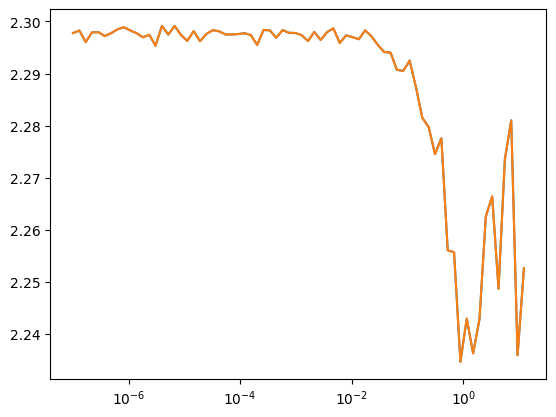

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Learning rate finder graph, the graph shows the relationship between learning rate (x-axis) and loss (y-axis)."
#| code-summary :  "From looking at the chart, it looks like the best learning rate is going to be between 10^-2 and 10^-1.... click to expand code"

# transform dataset and loader
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train

lrfind = LRFinderCB()
cbs = [TrainCB(), DeviceCB(), lrfind]

# fits data
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.0000001, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

# conv function takes in kernal size, stride (how many elements are skipped) and padding (number of zeros added to the edge of the input data)
# along with ni (features) input channels and output channels (feature maps)

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

#

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

model = nn.Sequential(*cnn_layers())

fit(model);

plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')



# Example of poorly initialized model (No input or weight initialization)

It will show training pipeline and corresponding metrics visualized through various charts. Annotations provide insights into the model's performance during training.

By paying attention to these key metrics and visual cues, we can assess the shortcomings in the input initialization and training regimen, specifically issues such as inactive neurons and poorly tuned input standardization (also know as input initializations). We can then compare them against previously un-initialized inputs and see any improvements.
<br>
<br>
**Key technical information for this section :**
<br>
<br>
**Conv 1,8,16,32,64 -> 10 :** A Convolution neural network showing the number of filters in each layer and ending with 10 output units.
<br> **Activation is nn.ReLU :** ReLU function introduces non-linearity to the model.
<br>
**Data normalisation :**  None
<br>
**weight normalization :**  None
<br>

accuracy,loss,epoch,train
0.188,2.247,0,train
0.196,2.225,0,eval
0.189,2.237,1,train
0.196,2.225,1,eval
0.189,2.237,2,train
0.196,2.224,2,eval


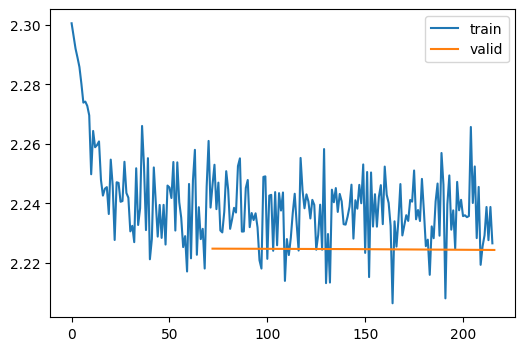

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Visualization of training metrics for learner model, batch numbers along the (x-axis) and loss (y-axis). The table shows the accuracy and loss of the model for the epoch and where it is a train and eval"
#| code-summary : "The chart loss shows the training was learning over the 1st 50 batches and flatlined, the first 50 batches didnt see much improvement, further tools are needed to improve the learning process .... click to expand code"

# improved function to include labelling for the stats
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
      fig, axes = get_grid(len(self), figsize=figsize)
      for ax, h in zip(axes.flat, self):
          im = ax.imshow(get_hist(h), origin='lower')  # Using imshow directly

          # Add labels, title, and colorbar for clarity
          ax.set_xlabel("Batch Number")
          ax.set_ylabel("Activation Value")
          ax.set_title("Layer " + "str(self.index(h))" + " Activations")
          cbar = plt.colorbar(im, ax=ax)
          cbar.set_label("Frequency")
      plt.tight_layout()  # Prevent overlap


    def dead_chart(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h), linewidth=3)
            ax.set_ylim(0,1)
            ax.set_xlabel("Batch Number")
            ax.set_ylabel("Activation Value")
            ax.set_title("Layer " + "str(self.index(h))" + " Dead Activations")
        plt.tight_layout()  # Prevent overlap

    def plot_stats(self, figsize=(10,4)):
        fig, axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1:
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        axs[0].set_xlabel("Batch Number")
        axs[1].set_xlabel("Batch Number")
        axs[0].set_ylabel("Mean Activation Value")
        axs[1].set_ylabel("Standard Deviation of Activation Value")
        plt.legend(fc.L.range(self))
        #plt.tight_layout()  # Prevent overlap

# transform dataset and loader
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train

# setup model for learning
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

# fits dataset
def fit(model, epochs=3, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

# conv function takes in kernal size, stride (how many elements are skipped) and padding (number of zeros added to the edge of the input data)
# along with ni (features) input channels and output channels (feature maps)
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

#
def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]
model = nn.Sequential(*cnn_layers())

#astats = ActivationStats(fc.risinstance(GeneralRelu))
astats = ActivationStats(fc.risinstance(nn.ReLU))

fit(model, xtra_cbs=[astats]);

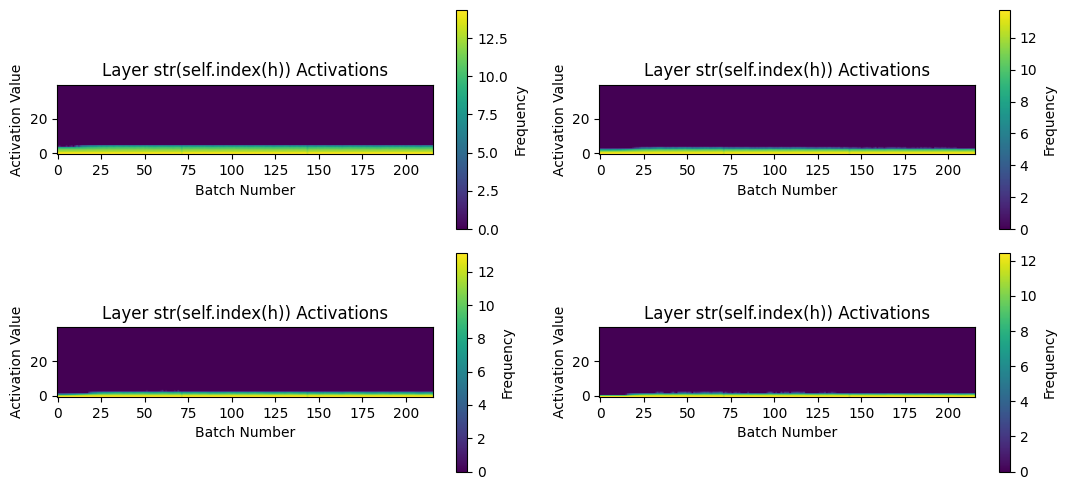

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show inactive neurons"
#| code-summary : "The color represents the frequency of activations in a specific range. Using the Viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently for that batch..... click to expand code"

astats.color_dim()

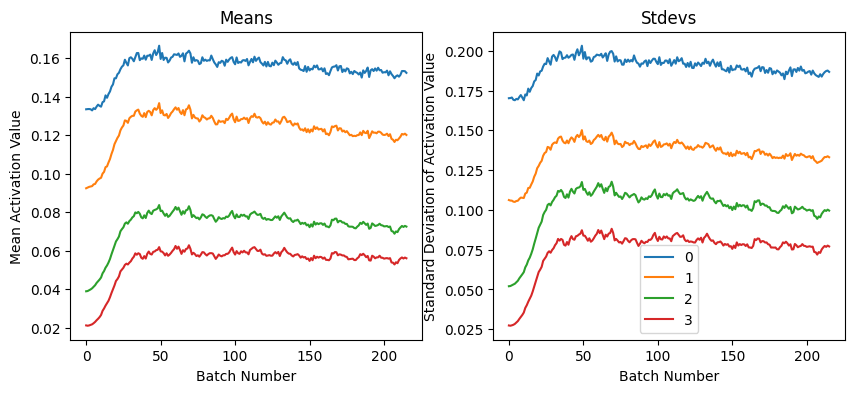

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer"
#| code-summary : "Plots of means and standard deviations for each layer activations. Means should be close to zero and Stdevs should be close to 1 for optimal training.... click to expand code"


astats.plot_stats()

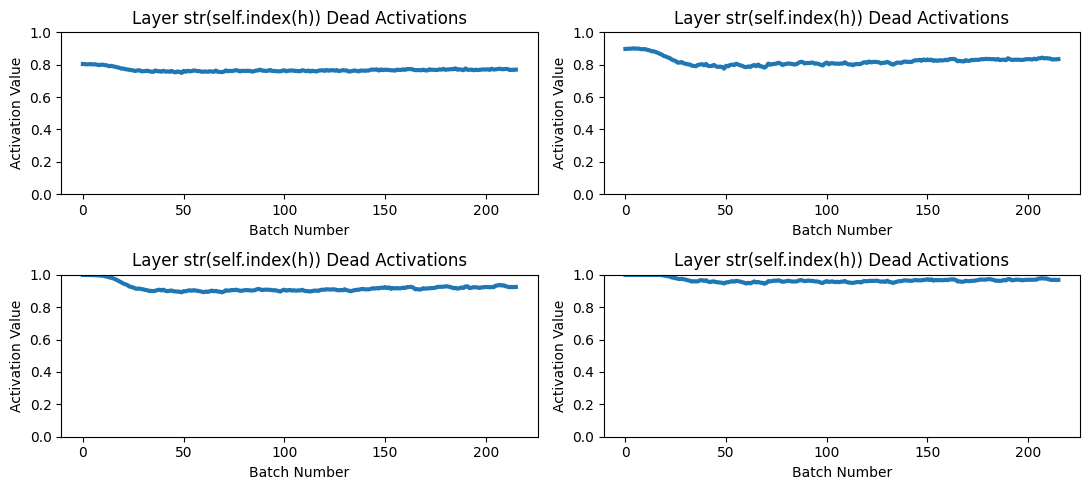

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result.... click to expand code"

astats.dead_chart()

# Improve the model by input normalization

To give the optimize algorithm every chance converge quicker, normalization the inputs to a mean of zero and standard deviation of 1 will help.  This can be done alone or with normalization the weights too.  The following section discusses normalization the inputs alone.

The key to this is to ensure that each feature contributes equally to the learning process, which is especially important when the features have different units or different scales.

It will show training pipeline and corresponding metrics visualized through various charts. Annotations provide insights into the model's performance during training.

By paying attention to these key metrics and visual cues, we can assess the shortcomings in the input initialization and training regimen, specifically issues such as inactive neurons and poorly tuned input normalization (also know as feature scaling). We can then compare them against previously un-initialized inputs and see any improvements.

**Key Technical Information for This Section:**

**Conv 1,8,16,32,64 -> 10 :** This denotes a Convolutional Neural Network with varying numbers of filters across different layers, culminating in 10 output units.
<br>
**Activation is nn.ReLU :** The model utilizes the ReLU (Rectified Linear Unit) activation function to introduce non-linearity, aiding in better approximations of complex functions.






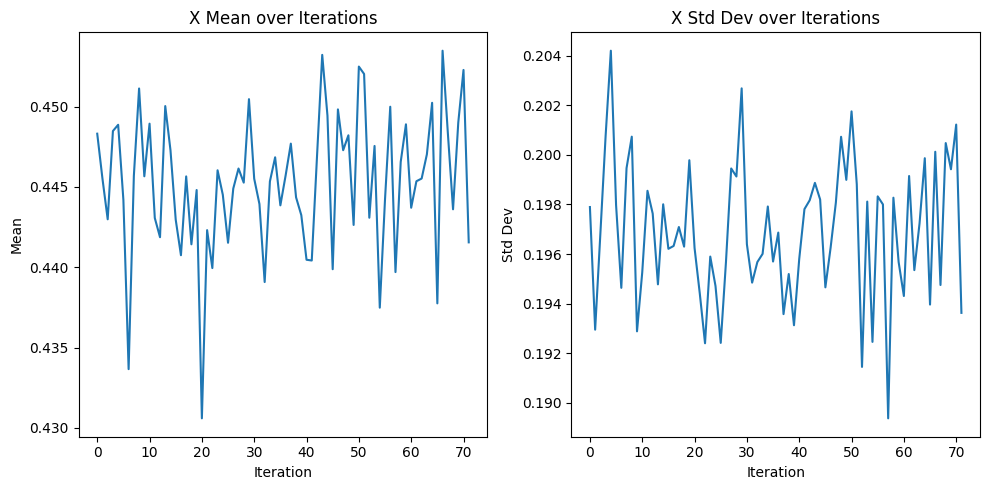

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Chart showing mean and standard deviation (y axis) over batches (x axis)"
#| code-summary : "Setting up the data without input initialization, you can see the mean is not near 0 and the standard deviation is not near 1 so not a optimal setup..... click to expand code"

xl,yl = 'image','label'

# transform dataset and loader
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]


tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)

#| echo: false
#| output: false

xmeans = []
xstds = []

for xb, yb in iter(dls.train):
    xmean, xstd = xb.mean(), xb.std()
    xmeans.append(xmean.item())
    xstds.append(xstd.item())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(xmeans, label='xmean')
plt.title('X Mean over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean')

plt.subplot(1, 2, 2)
plt.plot(xstds, label='xstd')
plt.title('X Std Dev over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Std Dev')

plt.tight_layout()
plt.show()


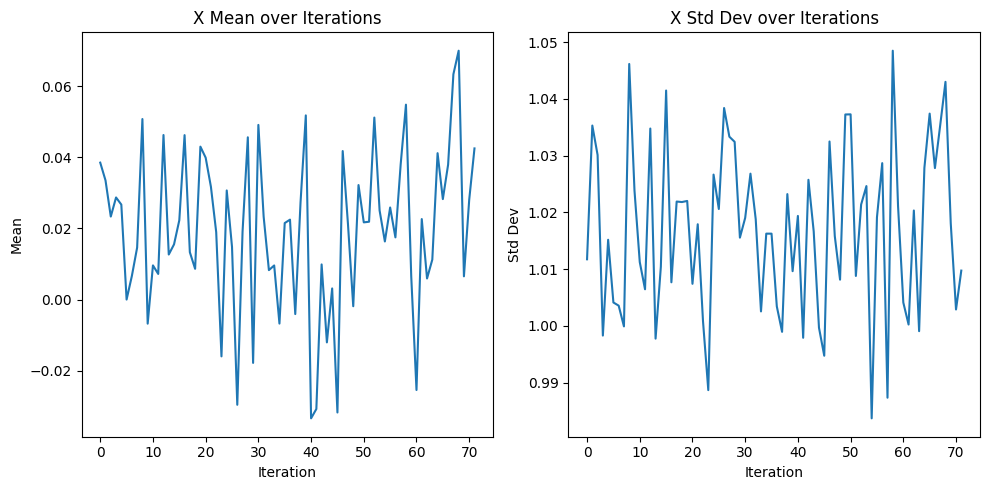

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Chart showing mean and standard deviation (y axis) over batches (x axis)"
#| code-summary : "This time with input initialization, you can see the mean is now near 0 and the standard deviation near 1 so it should help the model optimize quicker..... click to expand code"

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)


import matplotlib.pyplot as plt

xmeans = []
xstds = []

for xb, yb in iter(dls.train):
    xmean, xstd = xb.mean(), xb.std()
    xmeans.append(xmean.item())
    xstds.append(xstd.item())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(xmeans, label='xmean')
plt.title('X Mean over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean')

plt.subplot(1, 2, 2)
plt.plot(xstds, label='xstd')
plt.title('X Std Dev over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Std Dev')

plt.tight_layout()
plt.show()


accuracy,loss,epoch,train
0.185,2.248,0,train
0.196,2.225,0,eval
0.189,2.237,1,train
0.196,2.224,1,eval
0.189,2.237,2,train
0.196,2.224,2,eval


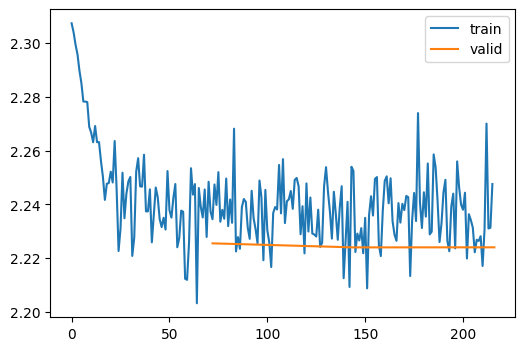

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Visualization of training metrics for learner model, batch numbers along the (x-axis) and loss (y-axis). The table shows the accuracy and loss of the model for the epoch and where it is a train and eval"
#| code-summary : "The code sets up a deep learning pipeline for training a CNN model on a dataset. It defines transformations for the dataset, specifies data loaders, metrics, and callbacks, and then creates a CNN model with specific convolutional layers before fitting the model using a learner object with a ratee of lr=0.2, and includes activation statistics.  it shows the model has flat lined at an accuracy of 0.19 and loss of 2.22, its likley that the model wont improve much with further training so other methods will be required to improve training further..... click to expand code"

# slightly better than last time but definatly not perfect>
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

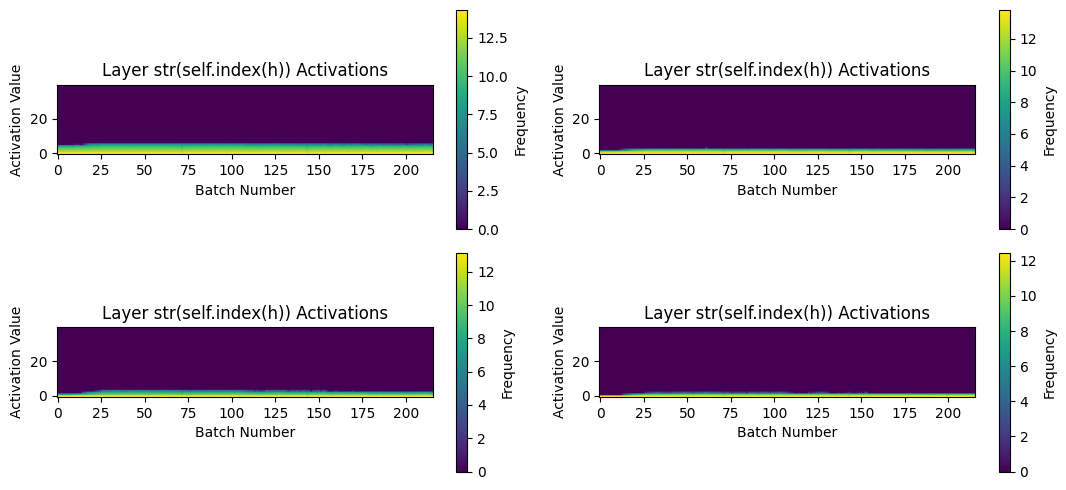

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show inactive neurons"
#| code-summary : "The color represents the frequency of activations in a specific range. Using the Viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently for that batch, this is still not looking good,as we have more yellow (more activations at the lower end of the scale) so we need to investigate other methods to help keep those neurons contributing to the end results...... click to expand code"

astats.color_dim()

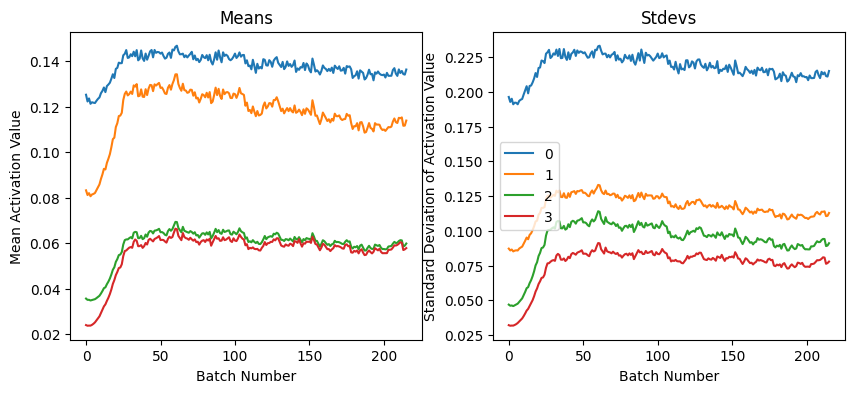

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer"
#| code-summary : "Plots of means and standard deviations for each layer activations. Means should be close to zero and Stdevs should be close to 1 for optimal training, we're far off that for the target standard deviations but they have improved very slighly, looks like the graph has raise by about 0.12.  These figures would explain why the training did not improve with further epochs.... click to expand code"


# stanard deviations still away from one but mean looks reasonable
astats.plot_stats()

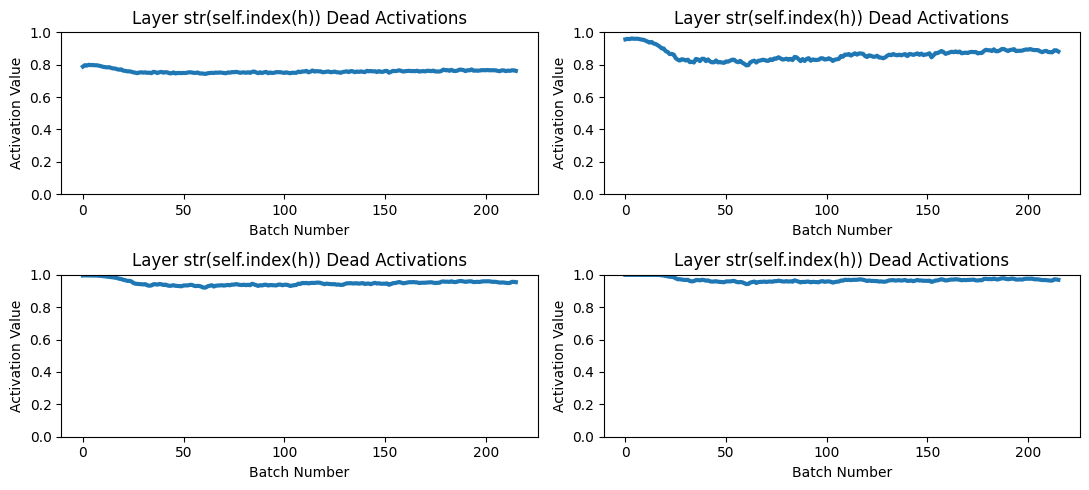

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result, this has improve slightly on the 1st layer but still not great, lots of neurons not contributing to the end prediction.... click to expand code"


# first layer quite bad and last layer is totally dead.
astats.dead_chart()


# Batch Normalization with Leaky ReLU activation and Kaiming normalization.
<br>

We are now changing 3 things. First is batch normalisation to control the inputs between each of layers, Leaky ReLU to keep more neurons alive so they contribute to the end result and finally weight initialization.

It will show training pipeline and corresponding metrics visualized through various charts. Annotations provide insights into the model's performance during training.

By paying attention to these key metrics and visual cues, we can assess the shortcomings in the input initialization and training regimen, specifically issues such as inactive neurons and poorly tuned input standardization (also know as input initializations). We can then compare them against previously un-initialized inputs and see any improvements.

**Key Technical Information for This Section:**

**Conv 1,8,16,32,64 -> 10 :** Similar to the previous model, this convolutional architecture has filter sizes escalating from 1 to 64, ending with 10 output units.
<br>
**Activation is Leaky ReLU :** We will now use Leaky ReLU  (instead of ReLu) as the activation function, which allows for a small, non-zero gradient when the unit is not active.   i.e. it passes a positve number for each of the activations.
<br>
**Data normalisation: is BatchNorm :** This will help calculate the data after each activation layer???
<br>
**Learning Rate 0.2 :** Initial training was conducted with a learning rate of 0.2.
<br>
Best Training So Far: This version of the model has shown the best training results compared to previous iterations.

What to Try Next : The section concludes with open questions and suggestions for future experiments to further enhance model performance.
The use of batch normalization and Leaky ReLU has led to improved training dynamics. The next aim is to implement LSUV as call back

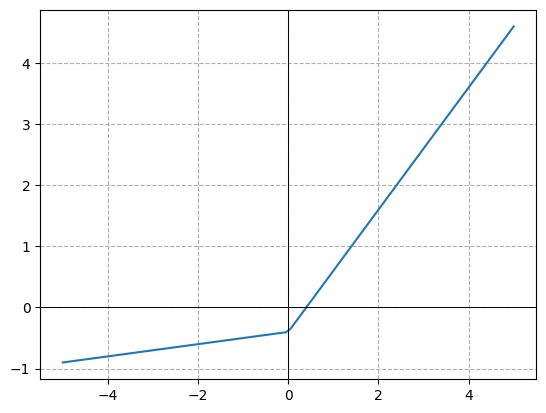

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plot of leaky, always passes through a positive value"
#| code-summary : "Transforms data from source import, plot functions and show a plot of Leaky ReLU..... click to expand code"

# transform dataset from source dsd
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train
#| Avoiding inactive Neurons: Leaky ReLU helps to mitigate the problem of "inactive neurons" that can occur with ReLU units,
# where neurons get stuck during training and always output a zero value. By allowing a small, non-zero output for negative inputs,
# Leaky ReLU ensures that gradients can still flow through the neuron, which can help to keep learning progressing.
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)
# visual representation of the new relu, left values Jeremeys example
plot_func(GeneralRelu(leak=0.1, sub=0.4))

accuracy,loss,epoch,train
0.599,1.220,0,train
0.799,0.680,0,eval
0.840,0.532,1,train
0.835,0.558,1,eval
0.867,0.444,2,train
0.830,0.559,2,eval


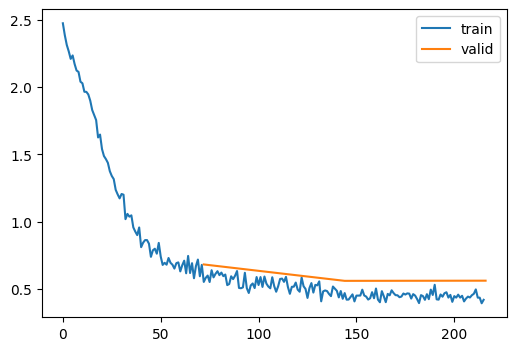

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Visualization of training metrics for learner model, batch numbers along the (x-axis) and loss (y-axis). The table shows the accuracy and loss of the model for the epoch and where it is a train and eval"
#| code-summary : "Sets up the model, initializes weights based on kaiming_normal with batch norm and runs fit.   The training shows massive improvement, dropping sharply over the first 50 batches, after that the rate of change decreases buts its still learning.  for future experiments, we could just carry on with the training process for more epochs as its still learning or we could change a few things up  ..... click to expand code"

def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)
#| initializes weights based on kaiming_normal_
def init_weights(m, leaky=0.):
    # checks for a instance of layer and module of the neural network
    # checks for a instance of 1d, 2d, 3d neural network
    #
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)):
      # creates the initialization of the weights, for a, anything that is not zero, standard relu is assumed.
      init.kaiming_normal_(m.weight, a=leaky)
# Creates a function based on relu with the parameters already applied
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

# Creates a function based on leaky being 0.1
iw = partial(init_weights, leaky=0.1)
# Returns a instance of a model
#
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # stores convolutions if not passed for later creation
    if nfs is None: nfs = [1,8,16,32,64]
    # Creates convolutions based on conv function for each of the layers in nfs
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
# collects mean and standard deviations of of each layer thats a ReLu
# astats = ActivationStats(fc.risinstance(nn.ReLU))
astats = ActivationStats(fc.risinstance(GeneralRelu))
# addeds all call backs into a list for later use.
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
set_seed(42)
# Creates instance of the model and then applys kaiming_normal to the weights
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# Creates a instance of the learner function
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show inactive neurons"
#| code-summary : "The color represents the frequency of activations in a specific range. Using the Viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently for that batch, this is looking really good,as we have more yellow (more activations all across the scale) so im happy with the results...... click to expand code"

astats.color_dim()

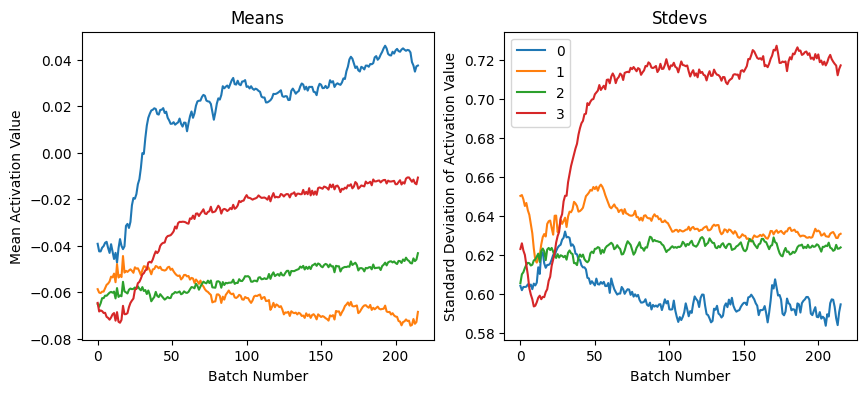

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer activations. Means should be close to zero and Stdevs should be close to 1 for optimal training, this is interesting asthe standard deviations are lower than 1 but the training went really well, would getting these closer to 1 help?????.... click to expand code"
#| code-summary : "?????? ..... click to expand code"

astats.plot_stats()


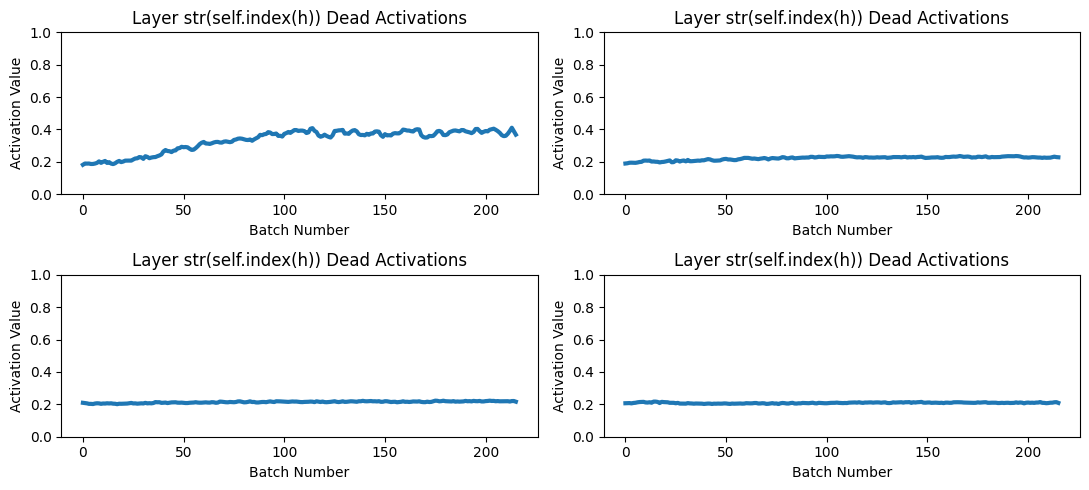

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result, this this is much better, they are all quite low so roughly 80% are contributing to the result (prediction).... click to expand code"

astats.dead_chart()

# implement LSUV initialization as a class

This new model is more basic than the first model. Theres no data normalization but we're keeping Leaky ReLU and changing the weight initialization to a custom LSUV callback.

It will show training pipeline and corresponding metrics visualized through various charts. Annotations provide insights into the model's performance during training.

By paying attention to these key metrics and visual cues, we can assess the shortcomings in the input initialization and training regimen, specifically issues such as inactive neurons and poorly tuned input standardization (also know as input initializations). We can then compare them against previously un-initialized inputs and see any improvements.

**Key Technical Information for This Section:**

**Conv 1,8,16,32,64 -> 10 :** Similar to the previous model, this convolutional architecture has filter sizes escalating from 1 to 64, ending with 10 output units.
<br>
**Activation is Leaky ReLU :** We will now use Leaky ReLU as the activation function, which allows for a small, non-zero gradient when the unit is not active.   i.e. it passes a positve number for each of the activations.
<br>
**Data normalisation :**  none
<br>
**weight normalization :**  LSUV
<br>
**Learning Rate 0.2 :** Initial training was conducted with a learning rate of 0.2.
<br>
What to Try Next : Weight initilization without input (data) normalization gave good results.  It would be a good experiment to  add some input (data) normalization like batch normalization.  However, the experiment has now finished and im happy with the results here.  

accuracy,loss,epoch,train
0.461,1.575,0,train
0.693,1.012,0,eval
0.758,0.783,1,train
0.754,0.817,1,eval
0.811,0.622,2,train
0.799,0.681,2,eval


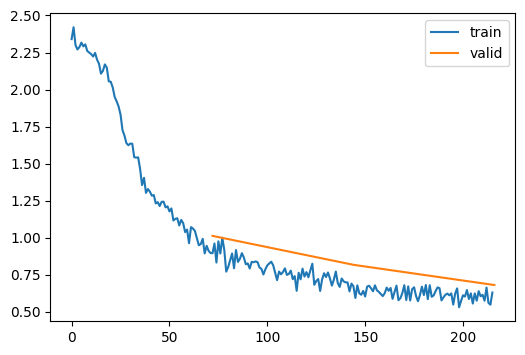

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Visualization of training metrics for learner model, batch numbers along the (x-axis) and loss (y-axis). The table shows the accuracy and loss of the model for the epoch and where it is a train and eval"
#| code-summary : "The code tranforms the data, Sets up the model with LSUV initilzing the weights and setting up Leaky ReLU.   The training shows massive improvement over using no initialization, it starts off 50 batches but doesnt learn as quick as 'Batch Normalization with Leaky ReLU activation and Kaiming normalization'. However, its still learning so we could just carry on with the training process but judging by previous experiments, its not optimal,  or we could try LSUV with a input normalization too..... click to expand code"


@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=1)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

# This class implements Layer-Sequential Unit-Variance Initialization (LSUV), a technique used to
# initialize the weights and biases of neural networks. LSUV aims to set these parameters such that
# during the forward pass, the variance of the activations remains close to 1. This avoids issues
# commonly associated with poor initialization, such as vanishing or exploding gradients.
# To achieve this, the class modifies the initial weights and biases in the context of a sample of input
# data, targeting a specified range for hardware/software-specific floating-point representation. This approach
# minimizes the risk of exceeding the numerical range, which can lead to unstable training dynamics, or
# put anotherway reduces the number of neurons contributing (deactivate) and the weight into the final result.
# Key methods within this class handle the adjustment of weights and biases, based on the calculated
#  variances and means of the activations. This is typically invoked at the beginning of the training
# process, prior to the main training loop.

# Note: Initial tests have shown effective results, although chart visualizations may
# require further refinement.

class LSUVStatsHook(Callback):
  # initialize and store all relevent details to object
  def __init__(self, modules_for_hooks, modules_for_weights, verbose=False, debug=False):
    self.mean = None
    self.std = None
    self.log = fc.noop if not verbose else print
    self.debug = debug
    #fc.store_attr()
    if self.debug : import pdb; pdb.set_trace()
    self.modules_for_hooks = modules_for_hooks
    self.modules_for_weights = modules_for_weights

  # update hooks
  def hook(self, module, input, output):
    #import pdb;pdb.set_trace()
    acts = output.detach().cpu()
    self.mean = acts.mean()
    self.std = acts.std()

  # apply hooks to relus, update weights and bias to convs
  def calc_apply_LSUV_weights_bias(self, learn, batch_of_data):
    # Get all of the modules that will be used for calculating the  lsuv
    if self.debug : import pdb; pdb.set_trace()
    self.log("self.modules_for_hooks is type", self.modules_for_hooks)
    self.log("GeneralRelu is type " , GeneralRelu)
    modules_to_apply_hooks = [o for o in learn.model.modules() if isinstance(o, self.modules_for_hooks)]
    self.log("modules to apply hooks to: ", modules_to_apply_hooks)
    module_to_update_weights = [o for o in learn.model.modules() if isinstance(o, self.modules_for_weights)]

    # Update the weights and bias's util desired range is achieved
    if self.debug : import pdb; pdb.set_trace()
    no_of_layers = len(modules_to_apply_hooks)
    for item in range(no_of_layers):
      self.log("entering layer : ", item)
      handle = modules_to_apply_hooks[item].register_forward_hook(hook_LUSV.hook)
      with torch.no_grad():
        while learn.model(batch_of_data) is not None and (abs(hook_LUSV.std-1)>1e-3 or abs(hook_LUSV.mean)>1e-3):
          self.log("update weights to modules: ",  module_to_update_weights[item])
          module_to_update_weights[item].bias -= hook_LUSV.mean
          module_to_update_weights[item].weight.data /= hook_LUSV.std
          self.log("standard deviation is :", hook_LUSV.std)
          self.log("mean is :              ", hook_LUSV.mean)
    # deregister the hook
    handle.remove()

  # calls calc_apply_LSUV_weights_bias to update weights and bias's
  def before_fit(self, learn):
    if self.debug : import pdb; pdb.set_trace()
    LSUVStatsHook.calc_apply_LSUV_weights_bias(self, learn, batch_of_data=xb)

# Custom callback with some debugging code commented out
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        #import pdb; pdb.set_trace()
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        #import pdb; pdb.set_trace()
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        #import pdb; pdb.set_trace()
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
        #print(f"loss : {learn.loss}, weight : {len(x)}")

# Load the metrics
metrics = MetricsCB(accuracy=MulticlassAccuracy())

# module for a custom Relu
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

# setup the LSUV hook to pass to the model
hook_LUSV = LSUVStatsHook(modules_for_hooks = GeneralRelu, modules_for_weights = nn.Conv2d,verbose=False,debug=False)

# setup the activation statics and module
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance((GeneralRelu, nn.ReLU)))

# setup the model and call fit
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

model = get_model(act_gr)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, hook_LUSV]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

learn.fit(3)

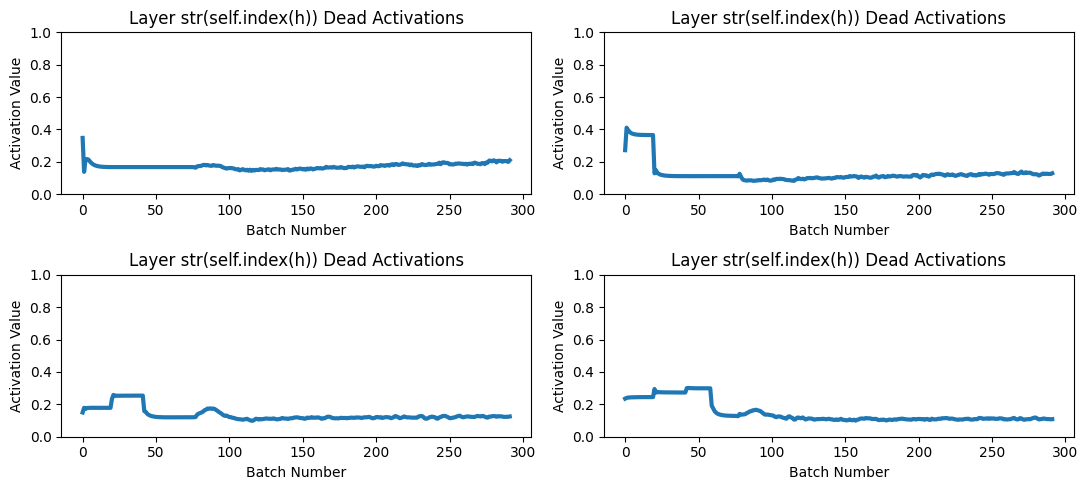

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result"
#| code-summary : "plots of inactive neurons (zero neurons) for each layer of the neural network, the lower the better so all neurons contribute to the result, this acceptable they are all quite low so roughly 80% are contributing to the result (prediction) except from at initial batches.... click to expand code"

astats.dead_chart()

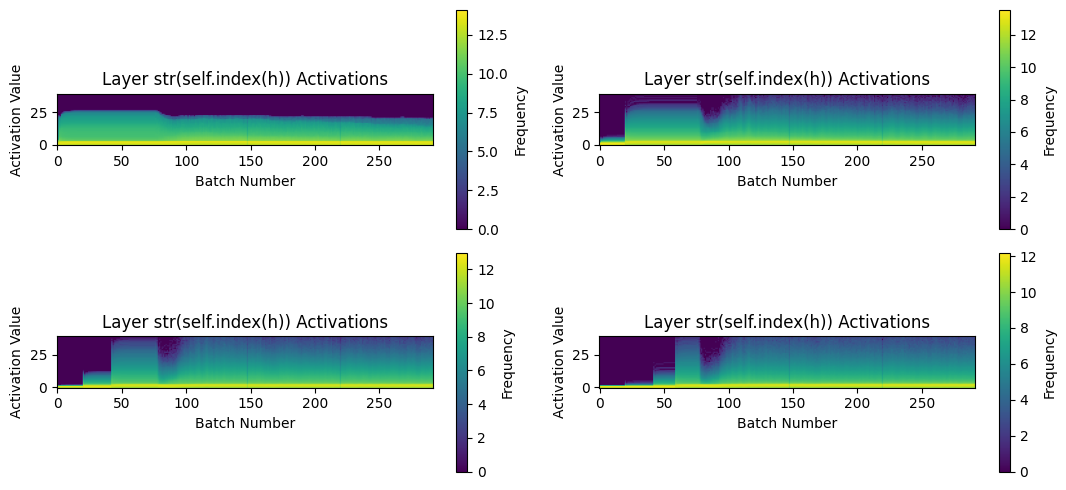

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Colour chart to show inactive neurons"
#| code-summary : "The color represents the frequency of activations in a specific range. Using the Viridis colormap, yellow indicates higher frequencies (many activations in that range), and purple indicates lower frequencies.   So, areas with more intense yellow mean those activation values occur more frequently for that batch, this is looking really good,as we have more yellow (more activations all across the scale) so im happy with the results apart from the start...... click to expand code"

astats.color_dim()




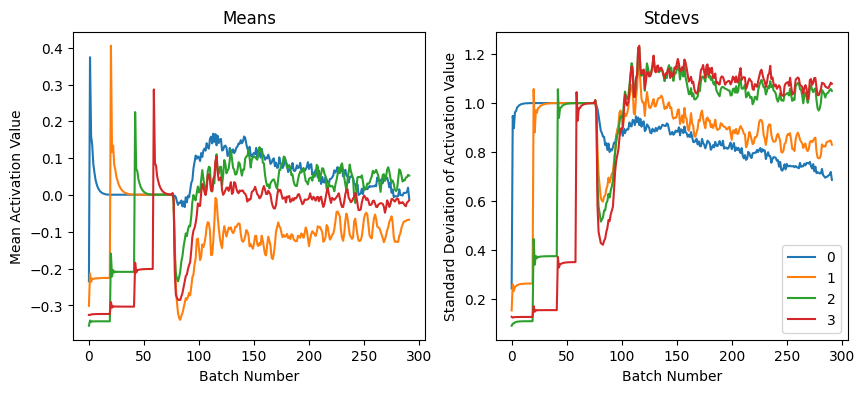

In [ ]:
#| echo: True
#| output: True
#| fig-cap : "Plots of means and standard deviations for each layer activations. Means should be close to zero and Stdevs should be close to 1 for optimal training, this is interesting as this really shows training got to the optimal weights after batch 75, layer 1 jumped up to 1 at batch 0, layer 2 jumped upto 1 at 25, layer 3 jumped up 1 at batch 50 and layer 3 jumped upto 75 so 25 between each of the layers. .... click to expand code"
#| code-summary : "?????? ..... click to expand code"

astats.plot_stats()

